## Multi-mode data

Finally we repeat the modelling part of this notebook using in this case multiple modes (fundamental, 1st, and 2nd).

In [1]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import json
from pathlib import Path
from PIL import Image
import torch
import torch.nn.functional as F

from functools import partial
from scipy.optimize import minimize, Bounds
from disba import PhaseDispersion

from surfacewaves import *
from dispersionspectra import *
from inversion import *

import ccfj
import scipy
from Dispersion.dispersion import get_dispersion


def get_cpr(thick, vs, periods):
    true_model = np.vstack([thick, vs*4, vs, np.ones_like(vs)]).T
    # Rayleigh-wave fundamental model dispersion curve 
    pd = PhaseDispersion(*true_model.T)
    cpr = [pd(periods[imode], mode=imode, wave="rayleigh") for imode in range(3)]

    return cpr

def random_thick_vs(thick, vs, periods, fluctuation_percentage=0.1):
    # 生成浮动值
    random_thick = thick * (1 + fluctuation_percentage * (2 * np.random.rand(len(thick)) - 1))
    random_vs = vs * (1 + fluctuation_percentage * (2 * np.random.rand(len(vs)) - 1))

    try:
        cpr = get_cpr(random_thick, random_vs, periods)
        return cpr, random_thick, random_vs
    except Exception as e:
        print(e)

def get_ccf(nt, dt, nx, dx, nfft, cpr):
    t, x = np.arange(nt)*dt, np.arange(nx)*dx
    # Wavelet
    wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
    wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

    # Data
    dshifts, fs, vfs = [], [], []
    for imode in range(3):
        dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                        np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
        dshifts.append(1./(imode+1)**0.8 * dshift_[np.newaxis])
        fs.append(f_)
        vfs.append(vf_)
    dshift = np.concatenate(dshifts).sum(0)
    return dshift, fs, vfs

def park(dshift, dx, dt, cmin, cmax, dc, fmin, fmax):
    f1, c1, img, U, t = get_dispersion(dshift.T, dx, dt, 
                                        cmin, cmax, dc, fmin, fmax)

    return f1, c1, img, U, t

def fj(dshift, dx, dt, cmin, cmax):
    nx, nt = dshift.shape
    x = np.arange(nx)*dx
    f = scipy.fftpack.fftfreq(nt,dt)[:nt//2]
    c = np.linspace(cmin, cmax, 1000)

    out = ccfj.fj_earthquake(dshift,x,c,f,fstride=1,itype=0,func=0)
    
    return f, c, out

def show_fj(f, c, out, fmin, fmax, ii, aa):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis("off")
    ax.imshow(out, aspect='auto', cmap='gray',
            extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')

    ax.margins(0)
    ax.set_xlim(fmin, fmax)
    ax.set_ylim(c.min(), c.max())
    fig.savefig(f'/home/lty/MyProjects/Seismology/diffseis/dataset/demultiple/data_train/data/{aa}{ii:03d}.png', 
                dpi=300,bbox_inches='tight', pad_inches=0)
    plt.close()

def show_label(f, c, out, cpr, fmin, fmax, ii, aa):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis("off")
    ax.imshow(np.zeros_like(out), aspect='auto', cmap='gray',
            extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
    for imode in range(3):
        ax.plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                    'white', lw=4)

    ax.margins(0)
    ax.set_xlim(fmin, fmax)
    ax.set_ylim(c.min(), c.max())

    fig.savefig(f'/home/lty/MyProjects/Seismology/diffseis/dataset/demultiple/data_train/labels/{aa}{ii:03d}.png', 
                dpi=300,bbox_inches='tight', pad_inches=0)
    plt.close()


def save_image(image_numpy, image_path, aspect_ratio=1.0):
    """Save a numpy image to the disk

    Parameters:
        image_numpy (numpy array) -- input numpy array
        image_path (str)          -- the path of the image
    """

    image_pil = Image.fromarray(image_numpy)
    h, w, _ = image_numpy.shape

    if aspect_ratio is None:
        pass
    elif aspect_ratio > 1.0:
        image_pil = image_pil.resize((h, int(w * aspect_ratio)), Image.BICUBIC)
    elif aspect_ratio < 1.0:
        image_pil = image_pil.resize((int(h / aspect_ratio), w), Image.BICUBIC)
    image_pil.save(image_path)

# 假设 record 中包含 ndarray，你可以先进行转换
def convert_ndarray(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_ndarray(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarray(i) for i in obj]
    else:
        return obj


/csim2/zhangzhiyu/miniconda3/envs/ccfj/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
import numpy as np
import random
import concurrent.futures


# Frequency axis
# fdisp = np.linspace(3, 40, 81)
# period = np.flipud(1/fdisp)         # Periods (must be sorted starting with low periods)

fdisp1, fdisp2, fdisp3 = np.linspace(3, 30, 3*(30-3)), np.linspace(10, 30, 3*(30-10)), np.linspace(15, 30, 3*(30-15))
fdisps = [fdisp1, fdisp2, fdisp3]
periods = [np.flipud(1/fdisp1), np.flipud(1/fdisp2), np.flipud(1/fdisp3)]

# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 81 # number of spatial samples
dx = 2.5 # spatial sampling in m
nfft = 2**10

dc = 3.
cmin, cmax = 50., 1000.
# fmin, fmax = fdisp.min(), fdisp.max()
fmin = np.min([np.min(fdisp) for fdisp in fdisps])
fmax = np.max([np.max(fdisp) for fdisp in fdisps])



# 原始数组
# thick = np.array([0.01, 0.02, 0.03, 0.01])
# vs = np.array([0.2, 0.4, 0.6, 0.8])
fluctuation_percentage = 0.2        # 定义浮动范围百分比


In [13]:
for _ in range(100):
    h1, h2, h3, h4 = 0.01, 0.02, 0.03, 1.0
    v1, v2, v3, v4 = 0.2, 0.4, 0.6, 1.8

    thick = np.array([h1, h2, h3, h4])
    vs = np.array([v1, v2, v3, v4])
    for ii in range(3):
        cpr, random_thick, random_vs = random_thick_vs(thick, vs, periods, fluctuation_percentage)
        # cmin = np.min([np.min(cpr[imode][1]) for imode in range(3)]) * 1e3
        cmax = np.max([np.max(cpr[imode][1]) for imode in range(3)]) * 1e3 + 100
        ccf, fs, vfs = get_ccf(nt, dt, nx, dx, nfft, cpr)
        f, c, out = fj(ccf, dx, dt, cmin, cmax)
        ind_fmax = np.argmin(np.abs(f-fmax))+1
        ind_fmin = np.argmin(np.abs(f-fmin))
        out = out[:, ind_fmin:ind_fmax]
        f = f[ind_fmin:ind_fmax]
        
        # 使用双线性插值缩放到 (256, 256)
        out_tensor = torch.tensor(out)
        out_tensor = out_tensor.unsqueeze(0).unsqueeze(0)  # 添加 batch 和 channel 维度
        resized = F.interpolate(out_tensor, size=(512, 128), mode='bilinear', align_corners=False)
        resized = resized.squeeze(0).squeeze(0)  # 最终为 (256, 256)# 去除 batch 和 channel 维度

        # 获得频散曲线坐标
        ff = [np.flipud(1/cpr[imode][0]) for imode in range(3)]
        cc = [1.e3*np.flipud(cpr[imode][1]) for imode in range(3)]
        fff = np.linspace(f.min(), f.max(), 128)
        ccc = np.linspace(c.min(), c.max(), 512)
        f_interp, c_interp, masks = [], [], []
        for f1, c1 in zip(ff, cc):
            # 初始化输出矩阵
            mask = np.zeros_like(resized, dtype=np.uint8)

            ind_fmin = np.argmin(np.abs(fff-f1.min()))
            ind_fmax = np.argmin(np.abs(fff-f1.max()))
            new_f = fff[ind_fmin:ind_fmax]
            # 使用 np.interp 进行插值
            new_c = np.interp(new_f, f1, c1)
            f_interp.append(new_f)
            c_interp.append(new_c)
            
            ind_f = np.searchsorted(fff, new_f)
            ind_c = np.searchsorted(ccc, new_c)
            for i, j in zip(ind_f, ind_c):
                mask[j, i] = 1
            masks.append(mask)


        # 保存 JSON
        record = {
            "data": resized.numpy(),
            "lines": [],
            "masks": []
        }
        for i in range(3):
            # record["lines"].append({
            #     "type": int(i),  # 假设类型就是索引；你可以自定义为别的
            #     "f": ind_f[i],
            #     "c": ind_c[i]
            # })
            record["masks"].append({
                "type": int(i),
                "mask": masks[i]
            })


        # 转换 record
        record_cleaned = convert_ndarray(record)
        aa = f"{''.join(f'{v:.3f}_{h:.3f}_' for v, h in zip(random_vs, random_thick))}.json"
        with open(Path("datasets_json",aa), 'w') as file:
            json.dump(record_cleaned, file)
        



In [ ]:
for _ in range(100):
    h1, h2, h3, h4 = 0.01, 0.02, 0.03, 1.0
    v1, v2, v3, v4 = 0.2, 0.4, 0.6, 1.8

    thick = np.array([h1, h2, h3, h4])
    vs = np.array([v1, v2, v3, v4])
    for ii in range(3):
        cpr, random_thick, random_vs = random_thick_vs(thick, vs, periods, fluctuation_percentage)
        # cmin = np.min([np.min(cpr[imode][1]) for imode in range(3)]) * 1e3
        cmax = np.max([np.max(cpr[imode][1]) for imode in range(3)]) * 1e3 + 100
        ccf, fs, vfs = get_ccf(nt, dt, nx, dx, nfft, cpr)
        # f, c, out = fj(ccf, dx, dt, cmin, cmax)
        # ind_fmax = np.argmin(np.abs(f-fmax))+1
        # ind_fmin = np.argmin(np.abs(f-fmin))
        # out = out[:, ind_fmin:ind_fmax]
        # f = f[ind_fmin:ind_fmax]
        
        f, c, out, U, t = get_dispersion(ccf.T, dx, dt, 
                                        cmin, cmax, dc, fmin, fmax)

        
        # 使用双线性插值缩放到 (256, 256)
        out_tensor = torch.tensor(out)
        out_tensor = out_tensor.unsqueeze(0).unsqueeze(0)  # 添加 batch 和 channel 维度
        resized = F.interpolate(out_tensor, size=(512, 128), mode='bilinear', align_corners=False)
        resized = resized.squeeze(0).squeeze(0)  # 最终为 (256, 256)# 去除 batch 和 channel 维度

        # 获得频散曲线坐标
        ff = [np.flipud(1/cpr[imode][0]) for imode in range(3)]
        cc = [1.e3*np.flipud(cpr[imode][1]) for imode in range(3)]
        fff = np.linspace(f.min(), f.max(), 128)
        ccc = np.linspace(c.min(), c.max(), 512)
        f_interp, c_interp, masks = [], [], []
        for f1, c1 in zip(ff, cc):
            # 初始化输出矩阵
            mask = np.zeros_like(resized, dtype=np.uint8)

            ind_fmin = np.argmin(np.abs(fff-f1.min()))
            ind_fmax = np.argmin(np.abs(fff-f1.max()))
            new_f = fff[ind_fmin:ind_fmax]
            # 使用 np.interp 进行插值
            new_c = np.interp(new_f, f1, c1)
            f_interp.append(new_f)
            c_interp.append(new_c)
            
            ind_f = np.searchsorted(fff, new_f)
            ind_c = np.searchsorted(ccc, new_c)
            for i, j in zip(ind_f, ind_c):
                mask[j, i] = 1
            masks.append(mask)


        # 保存 JSON
        record = {
            "data": resized.numpy(),
            "lines": [],
            "masks": []
        }
        for i in range(3):
            record["lines"].append({
                "type": int(i),  # 假设类型就是索引；你可以自定义为别的
            })
            record["masks"].append({
                "type": int(i),
                "mask": masks[i]
            })


        # 转换 record
        record_cleaned = convert_ndarray(record)
        aa = f"{''.join(f'{v:.3f}_{h:.3f}_' for v, h in zip(random_vs, random_thick))}.json"
        with open(Path("datasets_json",aa), 'w') as file:
            json.dump(record_cleaned, file)
        



In [6]:

h1, h2, h3, h4 = 0.01, 0.02, 0.03, 1.0
v1, v2, v3, v4 = 0.2, 0.4, 0.6, 1.8

thick = np.array([h1, h2, h3, h4])
vs = np.array([v1, v2, v3, v4])
for ii in range(3):
    cpr, random_thick, random_vs = random_thick_vs(thick, vs, periods, fluctuation_percentage)
    # cmin = np.min([np.min(cpr[imode][1]) for imode in range(3)]) * 1e3
    cmax = np.max([np.max(cpr[imode][1]) for imode in range(3)]) * 1e3 + 100
    ccf, fs, vfs = get_ccf(nt, dt, nx, dx, nfft, cpr)
    f, c, out = fj(ccf, dx, dt, cmin, cmax)
    ind_fmax = np.argmin(np.abs(f-fmax))+1
    ind_fmin = np.argmin(np.abs(f-fmin))
    out = out[:, ind_fmin:ind_fmax]
    f = f[ind_fmin:ind_fmax]
    
    # 使用双线性插值缩放到 (256, 256)
    out_tensor = torch.tensor(out)
    out_tensor = out_tensor.unsqueeze(0).unsqueeze(0)  # 添加 batch 和 channel 维度
    resized = F.interpolate(out_tensor, size=(512, 128), mode='bilinear', align_corners=False)
    resized = resized.squeeze(0).squeeze(0)  # 最终为 (256, 256)# 去除 batch 和 channel 维度

    # 获得频散曲线坐标
    ff = [np.flipud(1/cpr[imode][0]) for imode in range(3)]
    cc = [1.e3*np.flipud(cpr[imode][1]) for imode in range(3)]
    fff = np.linspace(f.min(), f.max(), 128)
    ccc = np.linspace(c.min(), c.max(), 512)
    f_interp, c_interp, masks = [], [], []
    f_128s, c_128s = [], []
    for f1, c1 in zip(ff, cc):
        # 初始化输出矩阵
        mask = np.zeros_like(resized, dtype=np.uint8)

        ind_fmin = np.argmin(np.abs(fff-f1.min()))
        ind_fmax = np.argmin(np.abs(fff-f1.max()))
        new_f = fff[ind_fmin:ind_fmax]
        # 使用 np.interp 进行插值
        new_c = np.interp(new_f, f1, c1)
        f_interp.append(new_f)
        c_interp.append(new_c)
        
        ind_f = np.searchsorted(fff, new_f)
        ind_c = np.searchsorted(ccc, new_c)
        f_128 = np.zeros_like(fff)
        c_128 = np.zeros_like(ccc)
        f_128[ind_f] = 1
        c_128[ind_c] = 1
        f_128s.append(f_128)
        c_128s.append(c_128)

plt.plot(f_128s[0], c_128s[0], 'k', lw=2)
plt.plot(f_128s[1], c_128s[1], 'k', lw=2)
plt.plot(f_128s[2], c_128s[2], 'k', lw=2)
plt.show()

In [8]:
out.min(), out.max()

(0.0001270408, 1.0)

In [4]:
ind_f.shape, ind_f.min(), ind_f.max()

((70,), 57, 126)

In [5]:
ind_c.shape, ind_c.min(), ind_c.max()

((70,), 187, 254)

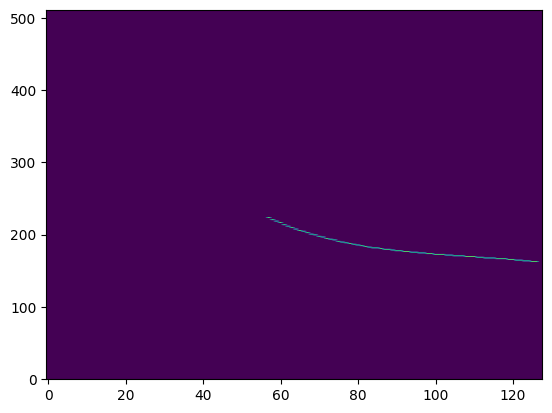

In [5]:
plt.imshow(mask, aspect='auto', origin='lower')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))
# ax.axis("off")
ax.imshow(resized.numpy(), aspect='auto', cmap='gray',
        extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')


style = ['*', 'x', 'p']
for imode in range(3):
    # ax.plot(fs[imode], vfs[imode]*1.e3, 'k', lw=2, label='Original')
    ax.plot(f_interp[imode], c_interp[imode], style[imode], lw=2, label='Original')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))
# ax.axis("off")
ax.imshow(out, aspect='auto', cmap='gray',
        extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')


style = ['*', 'x', 'p']
for imode in range(3):
    # ax.plot(fs[imode], vfs[imode]*1.e3, 'k', lw=2, label='Original')
    ax.plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), style[imode], lw=2, label='Original')